# Guide 2. Loading Bulk Stats and Viewing Them

This notebook is prepared for Moffat and Nichol by the NCSU Coastal Hazards Lab (Dr. Katherine Anarde, Levi Lavengood, Brooke Gaenzle, Elizabeth Farquhar) for the analysis, interpretation, and visualization of the bulk wave statistics for the data collected as part of the Frying Pan Shoals Hydrodynamic Characterization project (2024-2025). This is the second notebook in detailing specifically the processes and data from the bulk_stats _Sig1k.py script.

**Deployment Conditions** 

In the harbour on the day of deployment, there were peak wave heights of ~2.5-3 ft with periods of ~ 5 seconds coming from the South. The wind was ~ 8-10 knots, with ~10-15 knot gusts coming from the North East. The air temperature was 78 degrees fahrenheit. 

During the data collection period (August 20th to Seotember 19th), potential tropical cyclone eight developed off of the carolina coast on September 13th and continued to move inland until September 16th 2024. As a result of this storm, 12-20 inches of rainfall fell in ~ 2 days and winds increased. A king tide was present August 17 to August 21, resulting in higher water levels August 20 to August 26th. Similarly, a king tide was present from September 15 to September 23.

**Storage**

The bulk statistics are stored in h5 files like the other processed data files. The main difference for the bulk statistics, is that the groups that the processed data are stored in have been merged for the bulk statistics. This is possible since the bulk statistics are returned for every hour of sampling, so instead of the 14,400 samples per hour across multiple data fields we instead are left with just one averaged value per hour for each data field.

The bulk statistics are calculated in 1 hour averages which we call 'Chunks'. Each chunk consists of several overlapping 512 second segments called ensembles that are averaged together. We choose 512 second long ensembles since the length of the ensemble determines the max period of the waves we can observe, a shorter window and we may miss out on some longer period waves.

In [2]:
### Code to read in h5 files as detailed in the first guidebook
# Import necessary packages
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

dirpath = r'Z:\deployment_1\BulkStats\S0_103080'

files = os.listdir(dirpath) # list of files in Group 1

waves = {}
for file in files:
    file_path = os.path.join(dirpath, file)  # file path
    df = pd.read_hdf(file_path)  # read the file into a Pandas dataframe
    file_name = file.split('.')[0]  # file name 
    print(file_name)
    waves[file_name] = df  # store dataframe

GroupSpeed
Frequencies
WaveNumbers
Time
WaveCelerity
MeanPeriod
SignificantWaveHeight
DepthAveragedEastVeloctiy
DepthAveragedNorthVeloctiy
MeanDirection1
MeaanSpread1
MeanDirection2
MeanSpread2
DepthAveragedFlowDireciton
PressureSpectra
PressureEastVelCospectra
PressureNorthVelCospectra
EastVelSpectra
NorthVelSpectra


**Time**

The time data field stores the datetime assoicated with each chunk. It should be roughly evenly spaced one hour apart.

In [21]:
sorted = waves['Time'].sort_values(by=0)
print(sorted.iloc[800:850])

                             0
604 2024-09-10 15:30:00.126104
148 2024-09-10 15:30:00.126104
149 2024-09-10 16:30:00.126111
605 2024-09-10 16:30:00.126111
606 2024-09-10 17:30:00.126107
150 2024-09-10 17:30:00.126107
607 2024-09-10 18:30:00.126104
151 2024-09-10 18:30:00.126104
608 2024-09-10 19:30:00.126111
152 2024-09-10 19:30:00.126111
153 2024-09-10 20:30:00.126107
609 2024-09-10 20:30:00.126107
610 2024-09-10 21:30:00.126104
154 2024-09-10 21:30:00.126104
611 2024-09-10 22:30:00.126111
155 2024-09-10 22:30:00.126111
612 2024-09-10 23:30:00.126107
156 2024-09-10 23:30:00.126107
613 2024-09-11 00:30:00.126104
157 2024-09-11 00:30:00.126104
614 2024-09-11 01:30:00.126111
158 2024-09-11 01:30:00.126111
615 2024-09-11 02:30:00.125997
159 2024-09-11 02:30:00.125997
160 2024-09-11 03:30:00.126104
616 2024-09-11 03:30:00.126104
617 2024-09-11 04:30:00.126111
161 2024-09-11 04:30:00.126111
618 2024-09-11 05:30:00.125796
162 2024-09-11 05:30:00.125796
163 2024-09-11 06:30:00.126104
619 2024

In [32]:
for key in waves.keys():
    waves[key] = waves[key].reindex(sorted.index)

**Mean Period**

The mean wave period has units of XXX (seconds I think?). It is recorded as the average of the ensemble wave periods for each chunk. 

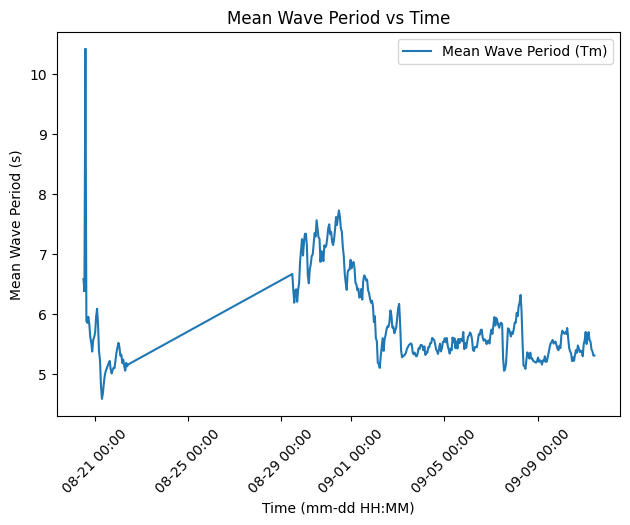

In [33]:
# Plot Mean Wave Period vs Time
plt.plot(waves["Time"], waves["MeanPeriod"], label="Mean Wave Period (Tm)")

# Formatting
plt.xlabel("Time (mm-dd HH:MM)")
plt.ylabel("Mean Wave Period (s)")
plt.title("Mean Wave Period vs Time")
plt.legend()
plt.tight_layout()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.xticks(rotation=45)
plt.show()

**Signifigant Wave Height**

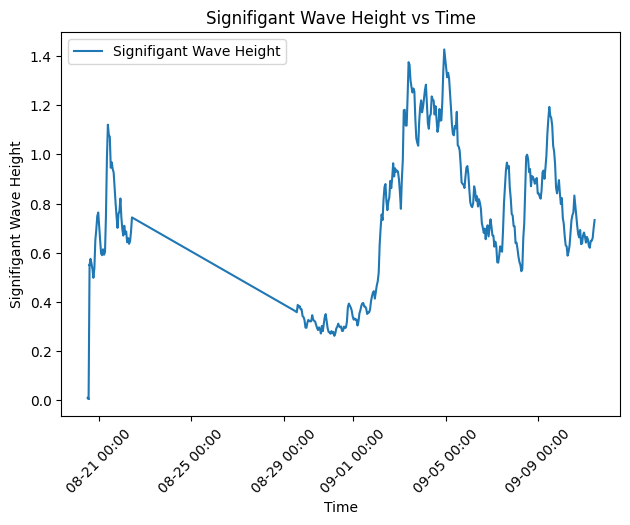

In [34]:
# Plot Mean Wave Period vs Time
plt.plot(waves["Time"], waves["SignificantWaveHeight"], label="Signifigant Wave Height")

# Formatting
plt.xlabel("Time")
plt.ylabel("Signifigant Wave Height")
plt.title("Signifigant Wave Height vs Time")
plt.legend()
plt.tight_layout()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.xticks(rotation=45)
plt.show()

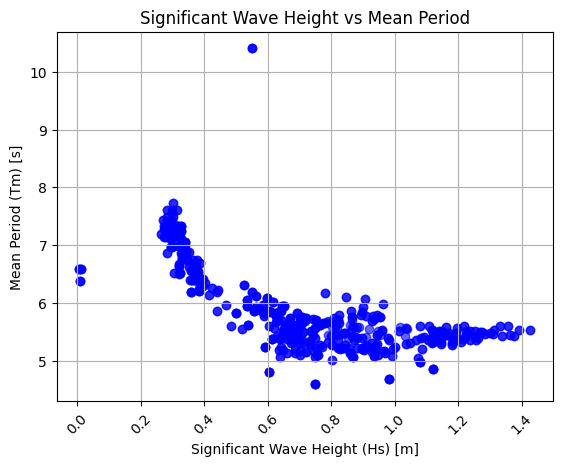

In [35]:
#Plot mean wave period vs signifigant wave height, you would expect larger waves to have longer periods
plt.scatter(waves['SignificantWaveHeight'], waves['MeanPeriod'], c='blue', alpha=0.6)
plt.title('Significant Wave Height vs Mean Period')
plt.xlabel('Significant Wave Height (Hs) [m]')
plt.ylabel('Mean Period (Tm) [s]')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Group Wave Speed**

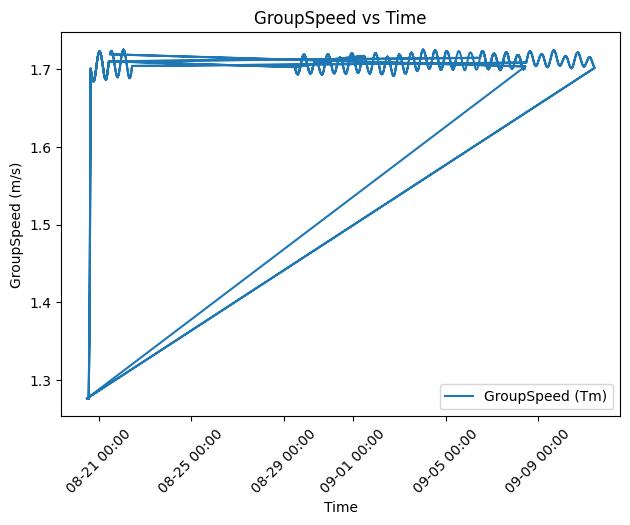

In [7]:
# Plot Group Wave Speed vs Time
plt.plot(waves["Time"], waves["GroupSpeed"], label="GroupSpeed (Tm)")

# Formatting
plt.xlabel("Time")
plt.ylabel("GroupSpeed (m/s)")
plt.title("GroupSpeed vs Time")
plt.legend()
plt.tight_layout()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.xticks(rotation=45)
plt.show()

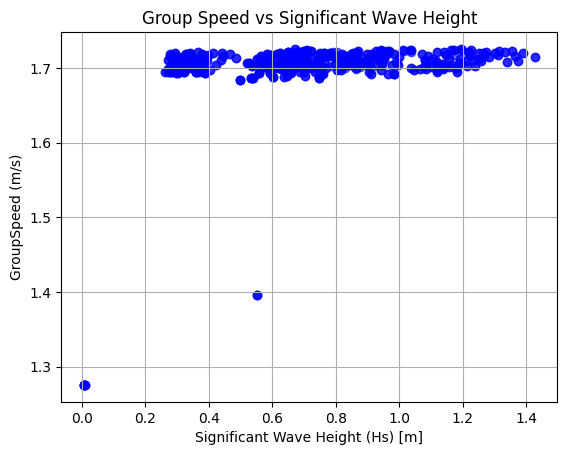

In [8]:
#Look at correlation between wave height and wave group speed
plt.scatter(waves['SignificantWaveHeight'], waves['GroupSpeed'], c='blue', alpha=0.6)
plt.title('Group Speed vs Significant Wave Height')
plt.xlabel('Significant Wave Height (Hs) [m]')
plt.ylabel("GroupSpeed (m/s)")
plt.grid(True)
plt.show()

**Wave Direction and Spread**

The wave direction contains the average direction of wave groups and the spread of this measurement. The direction is measured in degrees from North, i.e. East = 90, South = 180, West = 270, North = 0 or 360. The spread refers to the deviation in degrees that the wave packets may travel in from the mean direction. So a direction of 90 and a spread of 45 means you would expect the wave packets to be traveling on average due east with parts of the wabe packet propogating from ENE to ESE.

**Depth Averaged Current Velocity**

**Depth Averaged Current Direction**

**Wave Celerity, Wave Number, Frequency Range**